# Decision Trees

In this repository, we will grow a decision tree from scratch to predict bike inpatient status from repairs on the Rice Bikes transaction dataset.

## 0. Imports and Data

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns 

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from scipy.stats import mode

In [9]:
df = pd.read_csv("../../data/rb_tx_data.csv")
df = df.set_index("TransactionID")

df = df.replace(np.nan,0)

df = df.loc[(df['TotalCost']>0) & 
            (df['RepairCost']>0) &
            (df['TurnaroundTime']>0) &
            (df['TurnaroundTime']<38) # corresponds to two weeks
]


X = df.loc[:, df.columns[14:]].values
y = np.where(df['DayCreated']== df['DayCompleted'], 0, 1)


min_max_scaler = StandardScaler()
X = min_max_scaler.fit_transform(X)

X_train, X_val_test, y_train, y_val_test = train_test_split(X,y, test_size=0.3, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state = 42)


In [10]:
X = df.loc[:, df.columns[14:]]
X

,RearFlatRepair,AdjustRimBrake,InstallingLever,InstallBrakePads,InstallBrake,InstallBrakeCable,HeadsetAdjustment,AdjustDiskBrake,HeadsetOverhaul,WrapHandlebars,...,ReplaceBrakeLever,InstallSingle/UsedFender,FrontFlatRepair,StraightenBrakeLever,ReplaceRimTape,ShortenChain,InstallCartridgeBottomBracket,ReplaceFork,BikeBuild.1,AdjustChainTension
TransactionID,,,,,,,,,,,,,,,,,,,,,
9458,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9467,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9468,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12331,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12335,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1. Implementation

In [16]:
def gini(y):
    """
    Calculate the gini coefficient given the labels for a single node
    """
    _gini = 1 # start at 1
    samples = len(y)
    # get distinct labels
    unique_labels, label_counts = np.unique(y, return_counts=True)
    # decrement gini coefficient for each label
    for (label, count) in zip(unique_labels, label_counts):
        _gini -= (count / samples)**2      
        
    return _gini
    
    

In [17]:
def min_gini_split_rule(X, y):
    """
    Calculate the split rule that minimizes the weighted sum 
    of resulting children gini coefficients.
    
    Returns the resulting split rule by the tupe (j, v)
    where the left child contains all samples with feature_j <= v
    and the right child contains all samples with feature_i > v
    """
    samples = len(X)
    
    min_gini = float("inf")
    min_gini_split_rule = None

    # for each feature
    i = 0
    for j, feature in enumerate(X.T): # features along rows, samples along columns
        # get the unique feature values across all samples
        unique_values = np.unique(feature)
        for value in unique_values:
            i += 1
            # construct a candidate split on that value
            split_rule = (X[:, j] <= value)
            
            left_labels = y[split_rule]
            right_labels =y[np.invert(split_rule)] 
            
            # compute the gini coefficient of the resulting split
            w_l = len(left_labels) / samples
            w_r = len(right_labels) / samples
            split_gini = w_l * gini(left_labels) + w_r * gini(right_labels)
            
            # update minimum gini coefficient
            if (split_gini < min_gini):
                min_gini_split_rule = (j, value)
                min_gini = split_gini
    
    return min_gini_split_rule

In [18]:
class DecisionNode(object):
    
    def __init__(self, X, y, depth =0, max_depth=4):
        self.X = X
        self.y = y
        self.depth = depth
        self.max_depth = max_depth
        self.split_rule = None
        
        impure = len(np.unique(y) > 1)
        if (depth < max_depth) and impure:
            self.split()
        
    def split(self):
        (feature_index, feature_value)= min_gini_split_rule(self.X, self.y)
        self.split_rule = (feature_index, feature_value)
        
        left_split_rule = self.X[:, feature_index] <= feature_value
        right_split_rule = np.invert(left_split_rule)
        
        self.left_child =  DecisionNode(self.X[left_split_rule], 
                                        self.y[left_split_rule],
                                        depth = self.depth + 1,
                                        max_depth = self.max_depth
                           )
        self.right_child = DecisionNode(self.X[right_split_rule], 
                                        self.y[right_split_rule],
                                        depth = self.depth + 1,
                                        max_depth = self.max_depth
                            )    
    
    def predict(self, xi, regression = False):
        if self.split_rule is not None: #internal node
            (feature_index, feature_value) = self.split_rule
            if (xi[feature_index] <= feature_value):
                return self.left_child.predict(xi, regression)
            else:
                return self.right_child.predict(xi, regression)
        else: # leaf node
            if regression:
                return np.mean(self.y)
            else:
                return mode(self.y).mode[0]
            
        

## 2. Hyperparameter Selection

In [37]:

max_depths = list(range(20))
accuracies = []

for k in tqdm(max_depths):
    tree_k = DecisionNode(X_train, y_train, max_depth=k)
    y_pred_k = [tree_k.predict(xi) for xi in X_val]
    accuracy_k = accuracy_score(y_val, y_pred_k)
    accuracies.append(accuracy_k)
    
    

100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


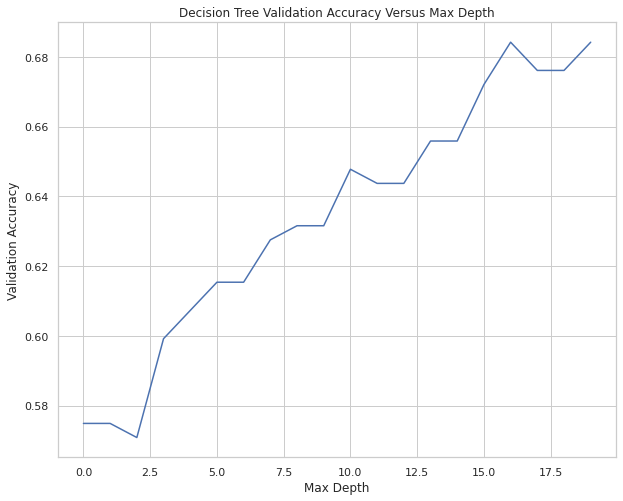

In [41]:
sns.set(style="whitegrid")
plt.figure(figsize= (10,8))
plt.plot(max_depths, accuracies)
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Decision Tree Validation Accuracy Versus Max Depth")
plt.show()

In [39]:
np.argmax(accuracies)

16

In [42]:
decision_tree = DecisionNode(X_train, y_train, max_depth=16)


In [43]:

y_pred = [decision_tree.predict(xi) for xi in X_test]
accuracy_score(y_test, y_pred)

0.7611336032388664

The resulting tree performs markedly well on the test set